In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/3deep'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

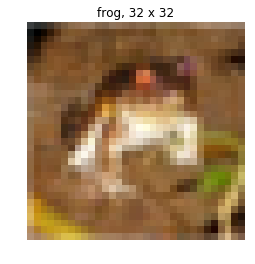

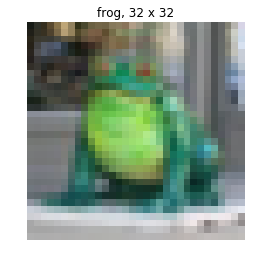

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:

def cnn_relu(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images,2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 3, slim.conv2d, 128, [3, 3], scope='conv2',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 5, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 6, slim.conv2d, 512, [3, 3], scope='conv4',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')

       
        net = slim.conv2d(net, 1024, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 1024, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits =cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/3deep
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/3deep/model.ckpt
INFO:tensorflow:St

INFO:tensorflow:global step 810: loss = 1.2775 (0.122 sec/step)
INFO:tensorflow:global step 820: loss = 1.3024 (0.127 sec/step)
INFO:tensorflow:global step 830: loss = 1.2960 (0.121 sec/step)
INFO:tensorflow:global step 840: loss = 1.3864 (0.117 sec/step)
INFO:tensorflow:global step 850: loss = 1.2946 (0.115 sec/step)
INFO:tensorflow:global step 860: loss = 1.2897 (0.122 sec/step)
INFO:tensorflow:global step 870: loss = 1.3480 (0.127 sec/step)
INFO:tensorflow:global step 880: loss = 1.4275 (0.113 sec/step)
INFO:tensorflow:global step 890: loss = 1.1775 (0.118 sec/step)
INFO:tensorflow:global step 900: loss = 1.2056 (0.137 sec/step)
INFO:tensorflow:global step 910: loss = 1.3885 (0.130 sec/step)
INFO:tensorflow:global step 920: loss = 1.2574 (0.125 sec/step)
INFO:tensorflow:global step 930: loss = 1.1890 (0.119 sec/step)
INFO:tensorflow:global step 940: loss = 1.3157 (0.126 sec/step)
INFO:tensorflow:global step 950: loss = 1.0839 (0.125 sec/step)
INFO:tensorflow:global step 960: loss = 

INFO:tensorflow:global step 2050: loss = 0.7989 (0.114 sec/step)
INFO:tensorflow:global step 2060: loss = 0.8320 (0.133 sec/step)
INFO:tensorflow:global step 2070: loss = 0.7351 (0.121 sec/step)
INFO:tensorflow:global step 2080: loss = 0.6253 (0.129 sec/step)
INFO:tensorflow:global step 2090: loss = 0.7055 (0.113 sec/step)
INFO:tensorflow:global step 2100: loss = 0.7338 (0.116 sec/step)
INFO:tensorflow:global step 2110: loss = 0.6859 (0.121 sec/step)
INFO:tensorflow:global step 2120: loss = 0.6508 (0.117 sec/step)
INFO:tensorflow:global step 2130: loss = 0.7646 (0.134 sec/step)
INFO:tensorflow:global step 2140: loss = 0.7880 (0.115 sec/step)
INFO:tensorflow:global step 2150: loss = 0.8023 (0.123 sec/step)
INFO:tensorflow:global step 2160: loss = 0.6055 (0.116 sec/step)
INFO:tensorflow:global step 2170: loss = 0.6228 (0.126 sec/step)
INFO:tensorflow:global step 2180: loss = 0.5572 (0.121 sec/step)
INFO:tensorflow:global step 2190: loss = 0.6175 (0.122 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3270: loss = 0.5046 (0.120 sec/step)
INFO:tensorflow:global step 3280: loss = 0.3663 (0.128 sec/step)
INFO:tensorflow:global step 3290: loss = 0.4343 (0.116 sec/step)
INFO:tensorflow:global step 3300: loss = 0.4973 (0.115 sec/step)
INFO:tensorflow:global step 3310: loss = 0.5670 (0.130 sec/step)
INFO:tensorflow:global step 3320: loss = 0.3543 (0.118 sec/step)
INFO:tensorflow:global step 3330: loss = 0.4859 (0.123 sec/step)
INFO:tensorflow:global step 3340: loss = 0.3990 (0.114 sec/step)
INFO:tensorflow:global step 3350: loss = 0.2828 (0.114 sec/step)
INFO:tensorflow:global step 3360: loss = 0.5063 (0.132 sec/step)
INFO:tensorflow:global step 3370: loss = 0.4334 (0.126 sec/step)
INFO:tensorflow:global step 3380: loss = 0.4161 (0.117 sec/step)
INFO:tensorflow:global step 3390: loss = 0.4850 (0.126 sec/step)
INFO:tensorflow:global step 3400: loss = 0.4351 (0.130 sec/step)
INFO:tensorflow:global step 3410: loss = 0.3842 (0.120 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4510: loss = 0.2425 (0.130 sec/step)
INFO:tensorflow:global step 4520: loss = 0.1945 (0.116 sec/step)
INFO:tensorflow:global step 4530: loss = 0.2988 (0.132 sec/step)
INFO:tensorflow:global step 4540: loss = 0.2532 (0.123 sec/step)
INFO:tensorflow:global step 4550: loss = 0.2917 (0.123 sec/step)
INFO:tensorflow:global step 4560: loss = 0.2143 (0.140 sec/step)
INFO:tensorflow:global step 4570: loss = 0.2391 (0.139 sec/step)
INFO:tensorflow:global step 4580: loss = 0.2848 (0.123 sec/step)
INFO:tensorflow:global step 4590: loss = 0.2098 (0.120 sec/step)
INFO:tensorflow:global step 4600: loss = 0.2746 (0.122 sec/step)
INFO:tensorflow:global step 4610: loss = 0.3533 (0.113 sec/step)
INFO:tensorflow:global step 4620: loss = 0.2696 (0.119 sec/step)
INFO:tensorflow:global step 4630: loss = 0.2504 (0.119 sec/step)
INFO:tensorflow:global step 4640: loss = 0.2969 (0.119 sec/step)
INFO:tensorflow:global step 4650: loss = 0.2765 (0.134 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5730: loss = 0.2184 (0.133 sec/step)
INFO:tensorflow:global step 5740: loss = 0.4700 (0.122 sec/step)
INFO:tensorflow:global step 5750: loss = 0.1930 (0.124 sec/step)
INFO:tensorflow:global step 5760: loss = 0.2363 (0.121 sec/step)
INFO:tensorflow:global step 5770: loss = 0.2125 (0.120 sec/step)
INFO:tensorflow:global step 5780: loss = 0.3459 (0.121 sec/step)
INFO:tensorflow:global step 5790: loss = 0.2590 (0.120 sec/step)
INFO:tensorflow:global step 5800: loss = 0.1274 (0.120 sec/step)
INFO:tensorflow:global step 5810: loss = 0.2004 (0.113 sec/step)
INFO:tensorflow:global step 5820: loss = 0.1152 (0.122 sec/step)
INFO:tensorflow:global step 5830: loss = 0.2142 (0.123 sec/step)
INFO:tensorflow:global step 5840: loss = 0.1567 (0.128 sec/step)
INFO:tensorflow:global step 5850: loss = 0.1366 (0.114 sec/step)
INFO:tensorflow:global step 5860: loss = 0.1340 (0.118 sec/step)
INFO:tensorflow:global step 5870: loss = 0.0808 (0.123 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6970: loss = 0.0702 (0.115 sec/step)
INFO:tensorflow:global step 6980: loss = 0.1624 (0.132 sec/step)
INFO:tensorflow:global step 6990: loss = 0.2097 (0.129 sec/step)
INFO:tensorflow:global step 7000: loss = 0.1824 (0.121 sec/step)
INFO:tensorflow:global step 7010: loss = 0.2420 (0.121 sec/step)
INFO:tensorflow:global step 7020: loss = 0.0783 (0.131 sec/step)
INFO:tensorflow:global step 7030: loss = 0.0979 (0.124 sec/step)
INFO:tensorflow:global step 7040: loss = 0.0387 (0.127 sec/step)
INFO:tensorflow:global step 7050: loss = 0.0593 (0.128 sec/step)
INFO:tensorflow:global step 7060: loss = 0.0889 (0.121 sec/step)
INFO:tensorflow:global step 7070: loss = 0.0890 (0.125 sec/step)
INFO:tensorflow:global step 7080: loss = 0.0842 (0.114 sec/step)
INFO:tensorflow:global step 7090: loss = 0.1981 (0.117 sec/step)
INFO:tensorflow:global step 7100: loss = 0.2301 (0.116 sec/step)
INFO:tensorflow:global step 7110: loss = 0.0704 (0.121 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8190: loss = 0.0551 (0.130 sec/step)
INFO:tensorflow:global step 8200: loss = 0.1222 (0.118 sec/step)
INFO:tensorflow:global step 8210: loss = 0.0371 (0.123 sec/step)
INFO:tensorflow:global step 8220: loss = 0.0949 (0.117 sec/step)
INFO:tensorflow:global step 8230: loss = 0.1578 (0.128 sec/step)
INFO:tensorflow:global step 8240: loss = 0.0152 (0.115 sec/step)
INFO:tensorflow:global step 8250: loss = 0.0179 (0.133 sec/step)
INFO:tensorflow:global step 8260: loss = 0.0875 (0.123 sec/step)
INFO:tensorflow:global step 8270: loss = 0.0429 (0.137 sec/step)
INFO:tensorflow:global step 8280: loss = 0.0994 (0.124 sec/step)
INFO:tensorflow:global step 8290: loss = 0.0871 (0.126 sec/step)
INFO:tensorflow:global step 8300: loss = 0.1294 (0.123 sec/step)
INFO:tensorflow:global step 8310: loss = 0.1063 (0.125 sec/step)
INFO:tensorflow:global step 8320: loss = 0.1036 (0.119 sec/step)
INFO:tensorflow:global step 8330: loss = 0.1076 (0.116 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9440: loss = 0.0667 (0.118 sec/step)
INFO:tensorflow:global step 9450: loss = 0.0770 (0.135 sec/step)
INFO:tensorflow:global step 9460: loss = 0.2982 (0.115 sec/step)
INFO:tensorflow:global step 9470: loss = 0.0918 (0.121 sec/step)
INFO:tensorflow:global step 9480: loss = 0.1176 (0.131 sec/step)
INFO:tensorflow:global step 9490: loss = 0.0163 (0.118 sec/step)
INFO:tensorflow:global step 9500: loss = 0.0654 (0.127 sec/step)
INFO:tensorflow:global step 9510: loss = 0.0793 (0.120 sec/step)
INFO:tensorflow:global step 9520: loss = 0.1425 (0.127 sec/step)
INFO:tensorflow:global step 9530: loss = 0.0986 (0.121 sec/step)
INFO:tensorflow:global step 9540: loss = 0.0880 (0.112 sec/step)
INFO:tensorflow:global step 9550: loss = 0.0380 (0.134 sec/step)
INFO:tensorflow:global step 9560: loss = 0.0216 (0.127 sec/step)
INFO:tensorflow:global step 9570: loss = 0.1115 (0.135 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/3deep/model.ckpt
INFO:tensorflow:Re

INFO:tensorflow:global step 10660: loss = 0.0269 (0.111 sec/step)
INFO:tensorflow:global step 10670: loss = 0.1003 (0.120 sec/step)
INFO:tensorflow:global step 10680: loss = 0.0328 (0.118 sec/step)
INFO:tensorflow:global step 10690: loss = 0.0452 (0.114 sec/step)
INFO:tensorflow:global step 10700: loss = 0.0399 (0.128 sec/step)
INFO:tensorflow:global step 10710: loss = 0.0287 (0.124 sec/step)
INFO:tensorflow:global step 10720: loss = 0.0821 (0.118 sec/step)
INFO:tensorflow:global step 10730: loss = 0.0474 (0.120 sec/step)
INFO:tensorflow:global step 10740: loss = 0.0591 (0.124 sec/step)
INFO:tensorflow:global step 10750: loss = 0.0620 (0.111 sec/step)
INFO:tensorflow:global step 10760: loss = 0.0799 (0.123 sec/step)
INFO:tensorflow:global step 10770: loss = 0.0874 (0.147 sec/step)
INFO:tensorflow:global step 10780: loss = 0.0991 (0.119 sec/step)
INFO:tensorflow:global step 10790: loss = 0.0349 (0.129 sec/step)
INFO:tensorflow:global step 10800: loss = 0.0894 (0.132 sec/step)
INFO:tenso

INFO:tensorflow:global step 11890: loss = 0.0181 (0.126 sec/step)
INFO:tensorflow:global step 11900: loss = 0.0036 (0.121 sec/step)
INFO:tensorflow:global step 11910: loss = 0.0219 (0.114 sec/step)
INFO:tensorflow:global step 11920: loss = 0.0684 (0.133 sec/step)
INFO:tensorflow:global step 11930: loss = 0.0228 (0.124 sec/step)
INFO:tensorflow:global step 11940: loss = 0.0185 (0.139 sec/step)
INFO:tensorflow:global step 11950: loss = 0.0361 (0.121 sec/step)
INFO:tensorflow:global step 11960: loss = 0.0375 (0.110 sec/step)
INFO:tensorflow:global step 11970: loss = 0.0648 (0.133 sec/step)
INFO:tensorflow:global step 11980: loss = 0.0824 (0.121 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/3deep/model.ckpt
INFO:tensorflow:Recording summary at step 11986.
INFO:tensorflow:global step 11990: loss = 0.0608 (0.117 sec/step)
INFO:tensorflow:global step 12000: loss = 0.0126 (0.120 sec/step)
INFO:tensorflow:global step 12010: loss = 0.0176 (0.123 sec/step)
INFO:tensorflow:globa

INFO:tensorflow:global step 13100: loss = 0.0249 (0.119 sec/step)
INFO:tensorflow:global step 13110: loss = 0.0510 (0.129 sec/step)
INFO:tensorflow:global step 13120: loss = 0.0376 (0.121 sec/step)
INFO:tensorflow:global step 13130: loss = 0.0738 (0.122 sec/step)
INFO:tensorflow:global step 13140: loss = 0.0798 (0.126 sec/step)
INFO:tensorflow:global step 13150: loss = 0.0341 (0.125 sec/step)
INFO:tensorflow:global step 13160: loss = 0.0172 (0.130 sec/step)
INFO:tensorflow:global step 13170: loss = 0.0755 (0.126 sec/step)
INFO:tensorflow:global step 13180: loss = 0.0432 (0.122 sec/step)
INFO:tensorflow:global step 13190: loss = 0.0581 (0.128 sec/step)
INFO:tensorflow:global step 13200: loss = 0.0829 (0.125 sec/step)
INFO:tensorflow:global step 13210: loss = 0.0297 (0.122 sec/step)
INFO:tensorflow:global step 13220: loss = 0.0084 (0.126 sec/step)
INFO:tensorflow:global step 13230: loss = 0.0219 (0.125 sec/step)
INFO:tensorflow:global step 13240: loss = 0.0663 (0.119 sec/step)
INFO:tenso

INFO:tensorflow:global step 14330: loss = 0.0643 (0.136 sec/step)
INFO:tensorflow:global step 14340: loss = 0.0140 (0.117 sec/step)
INFO:tensorflow:global step 14350: loss = 0.0170 (0.113 sec/step)
INFO:tensorflow:global step 14360: loss = 0.0608 (0.143 sec/step)
INFO:tensorflow:global step 14370: loss = 0.0222 (0.114 sec/step)
INFO:tensorflow:global step 14380: loss = 0.0603 (0.129 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/3deep/model.ckpt
INFO:tensorflow:Recording summary at step 14387.
INFO:tensorflow:global step 14390: loss = 0.0460 (0.122 sec/step)
INFO:tensorflow:global step 14400: loss = 0.0964 (0.118 sec/step)
INFO:tensorflow:global step 14410: loss = 0.1174 (0.118 sec/step)
INFO:tensorflow:global step 14420: loss = 0.0712 (0.114 sec/step)
INFO:tensorflow:global step 14430: loss = 0.0144 (0.117 sec/step)
INFO:tensorflow:global step 14440: loss = 0.0266 (0.124 sec/step)
INFO:tensorflow:global step 14450: loss = 0.0916 (0.121 sec/step)
INFO:tensorflow:globa

INFO:tensorflow:global step 15540: loss = 0.0891 (0.115 sec/step)
INFO:tensorflow:global step 15550: loss = 0.0448 (0.119 sec/step)
INFO:tensorflow:global step 15560: loss = 0.0064 (0.125 sec/step)
INFO:tensorflow:global step 15570: loss = 0.0104 (0.120 sec/step)
INFO:tensorflow:global step 15580: loss = 0.0397 (0.148 sec/step)
INFO:tensorflow:global step 15590: loss = 0.0264 (0.130 sec/step)
INFO:tensorflow:global step 15600: loss = 0.0637 (0.131 sec/step)
INFO:tensorflow:global step 15610: loss = 0.0242 (0.111 sec/step)
INFO:tensorflow:global step 15620: loss = 0.0539 (0.133 sec/step)
INFO:tensorflow:global step 15630: loss = 0.0680 (0.110 sec/step)
INFO:tensorflow:global step 15640: loss = 0.0381 (0.111 sec/step)
INFO:tensorflow:global step 15650: loss = 0.0394 (0.120 sec/step)
INFO:tensorflow:global step 15660: loss = 0.1212 (0.132 sec/step)
INFO:tensorflow:global step 15670: loss = 0.0949 (0.116 sec/step)
INFO:tensorflow:global step 15680: loss = 0.0868 (0.117 sec/step)
INFO:tenso

INFO:tensorflow:global step 16770: loss = 0.0284 (0.117 sec/step)
INFO:tensorflow:global step 16780: loss = 0.0701 (0.112 sec/step)
INFO:tensorflow:global step 16790: loss = 0.0158 (0.127 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/3deep/model.ckpt
INFO:tensorflow:Recording summary at step 16792.
INFO:tensorflow:global step 16800: loss = 0.0019 (0.127 sec/step)
INFO:tensorflow:global step 16810: loss = 0.0171 (0.121 sec/step)
INFO:tensorflow:global step 16820: loss = 0.0031 (0.125 sec/step)
INFO:tensorflow:global step 16830: loss = 0.0492 (0.115 sec/step)
INFO:tensorflow:global step 16840: loss = 0.0109 (0.130 sec/step)
INFO:tensorflow:global step 16850: loss = 0.0498 (0.122 sec/step)
INFO:tensorflow:global step 16860: loss = 0.0339 (0.116 sec/step)
INFO:tensorflow:global step 16870: loss = 0.0335 (0.117 sec/step)
INFO:tensorflow:global step 16880: loss = 0.0575 (0.120 sec/step)
INFO:tensorflow:global step 16890: loss = 0.0153 (0.114 sec/step)
INFO:tensorflow:globa

INFO:tensorflow:global step 17980: loss = 0.0104 (0.121 sec/step)
INFO:tensorflow:global step 17990: loss = 0.0226 (0.125 sec/step)
INFO:tensorflow:global step 18000: loss = 0.0175 (0.142 sec/step)
INFO:tensorflow:global step 18010: loss = 0.0490 (0.116 sec/step)
INFO:tensorflow:global step 18020: loss = 0.0315 (0.120 sec/step)
INFO:tensorflow:global step 18030: loss = 0.0862 (0.124 sec/step)
INFO:tensorflow:global step 18040: loss = 0.0292 (0.128 sec/step)
INFO:tensorflow:global step 18050: loss = 0.0044 (0.119 sec/step)
INFO:tensorflow:global step 18060: loss = 0.0551 (0.122 sec/step)
INFO:tensorflow:global step 18070: loss = 0.0527 (0.115 sec/step)
INFO:tensorflow:global step 18080: loss = 0.0046 (0.120 sec/step)
INFO:tensorflow:global step 18090: loss = 0.0108 (0.129 sec/step)
INFO:tensorflow:global step 18100: loss = 0.0170 (0.119 sec/step)
INFO:tensorflow:global step 18110: loss = 0.0020 (0.114 sec/step)
INFO:tensorflow:global step 18120: loss = 0.0124 (0.119 sec/step)
INFO:tenso

INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/3deep/model.ckpt
INFO:tensorflow:Recording summary at step 19207.
INFO:tensorflow:global step 19210: loss = 0.0071 (0.114 sec/step)
INFO:tensorflow:global step 19220: loss = 0.0265 (0.118 sec/step)
INFO:tensorflow:global step 19230: loss = 0.0055 (0.115 sec/step)
INFO:tensorflow:global step 19240: loss = 0.0590 (0.125 sec/step)
INFO:tensorflow:global step 19250: loss = 0.0247 (0.116 sec/step)
INFO:tensorflow:global step 19260: loss = 0.0697 (0.119 sec/step)
INFO:tensorflow:global step 19270: loss = 0.1081 (0.117 sec/step)
INFO:tensorflow:global step 19280: loss = 0.0230 (0.129 sec/step)
INFO:tensorflow:global step 19290: loss = 0.0709 (0.116 sec/step)
INFO:tensorflow:global step 19300: loss = 0.0131 (0.117 sec/step)
INFO:tensorflow:global step 19310: loss = 0.0842 (0.114 sec/step)
INFO:tensorflow:global step 19320: loss = 0.0857 (0.122 sec/step)
INFO:tensorflow:global step 19330: loss = 0.0919 (0.123 sec/step)
INFO:tensorflow:globa

In [8]:
%%time

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-04-08:29:43
INFO:tensorflow:Restoring parameters from /tmp/cifar10/3deep/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-04-08:29:44
eval/FalsePositives: 1.000000
eval/FalseNegatives: 3.000000
eval/TruePositives: 113.000000
eval/Accuracy: 0.765625
eval/mse: 3.406250
eval/TrueNegatives: 11.000000
eval/Recall5: 0.953125
CPU times: user 1.97 s, sys: 304 ms, total: 2.27 s
Wall time: 1.38 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/3deep/model.ckpt-20000


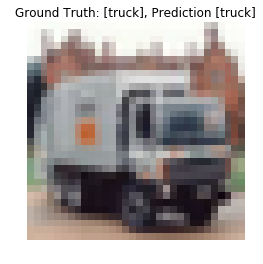

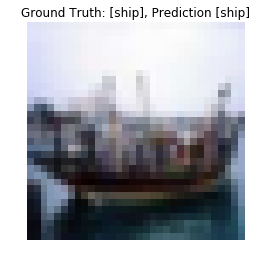

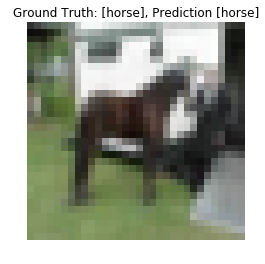

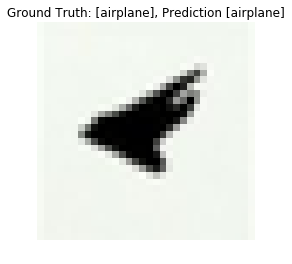

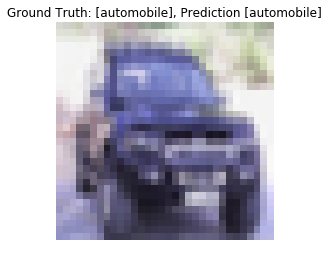

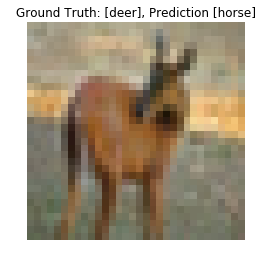

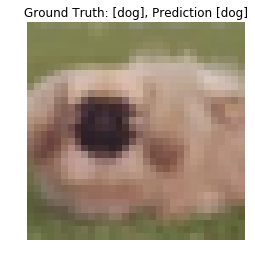

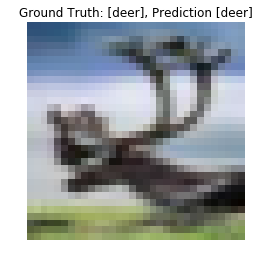

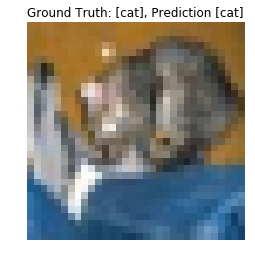

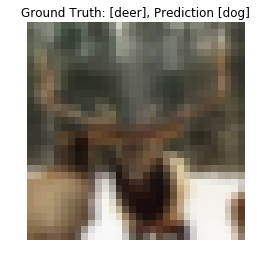

CPU times: user 3.56 s, sys: 1.82 s, total: 5.38 s
Wall time: 1.91 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()